In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 5
Total threads: 20,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38751,Workers: 5
Dashboard: /proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:45689,Total threads: 4
Dashboard: /proxy/33605/status,Memory: 25.60 GiB
Nanny: tcp://127.0.0.1:43111,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [4]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

# salterature of meltwater at the freezing point calculated with the in situ salinity:
Tfreezing_insituS = 'accessom2-GPC004'
# temperature of meltwater at the freezing point calculated with the 0 salinity:
Tfreezing_zeroS = 'accessom2-GPC005'
# temperature of meltwater equal to the minimum of the above two temperatures:
Tfreezing_min = 'accessom2-GPC006'

start_time='2150-01-01'
end_time='2152-01-01'

lat_slice  = slice(-80,-59)

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC004/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC005/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC006/',]
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC004
Indexing experiment: accessom2-GPC005
Indexing experiment: accessom2-GPC006


0it [00:00, ?it/s]


0

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [7]:
# First plot map of bottom temperature to see regions

In [8]:
start_time='2154-01-01'
end_time='2155-01-01'

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_con = temp_con.mean('time')

temp_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min = temp_Tfreezing_min.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_Tfreezing_min = temp_Tfreezing_min.mean('time')

In [9]:
# select out bottom values:
depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_Tfreezing_min = temp_Tfreezing_min.where(depth_array.st_ocean >= max_depth)
bottom_temp_Tfreezing_min = bottom_temp_Tfreezing_min.sum(dim = 'st_ocean')
bottom_temp_Tfreezing_min = bottom_temp_Tfreezing_min.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

In [10]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map

In [11]:
#Shelf
ht = cc.querying.getvar(control,'ht', master_session, n=1) 
ht = ht.sel(yt_ocean = slice(-90, -59))
land_mask = (ht*0).fillna(1)
yt_ocean = ht.yt_ocean.values
xt_ocean = ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

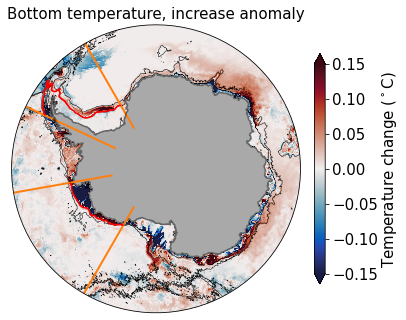

In [12]:
scale_max = 0.15

fig  = plt.figure(1, figsize = (10,8))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# up:
# setup stereo projection:
ax = fig.add_axes([0.0, 0.5, 0.5, 0.5],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_min-bottom_temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Bottom temperature, increase anomaly',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())

#Shelf
#ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
#ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

# Add transect lines:
# Wedell:
lon1=-30
lon2=-65
#if lon1 < 0: lon1 = -lon1
#if lon2 < 0: lon2 = -lon2
aa = np.argmin(abs(xt_ocean-lon1))
bb = np.argmin(abs(xt_ocean-lon2))
aaa = min(aa,bb)
bbb = max(aa,bb)
plt.plot([lon1,lon1],[-80,-59],'C1',linewidth=2,transform = ccrs.PlateCarree())
plt.plot([lon2,lon2],[-80,-59],'C1',linewidth=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

#Shelf
ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean[aaa:bbb], yt_ocean, shelf_mask[:,aaa:bbb].values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

# Amundsen:
lon1=-100
lon2=-150
#if lon1 < 0: lon1 = -lon1
#if lon2 < 0: lon2 = -lon2
aa = np.argmin(abs(xt_ocean-lon1))
bb = np.argmin(abs(xt_ocean-lon2))
aaa = min(aa,bb)
bbb = max(aa,bb)
plt.plot([lon1,lon1],[-80,-59],'C1',linewidth=2,transform = ccrs.PlateCarree())
plt.plot([lon2,lon2],[-80,-59],'C1',linewidth=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

#Shelf
#ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean[aaa:bbb], yt_ocean, shelf_mask[:,aaa:bbb].values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
        
# colorbar:
cbaxes = fig.add_axes([0.47, 0.55, 0.015, 0.4])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Temperature change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

#figure_path = figdir+'map_bottom_temp_with_transect_locations.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

In [13]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_map = np.nan_to_num(shelf_mask)
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
shelf_mask = shelf_mask.sel(yt_ocean=lat_slice)

In [14]:
# thickness area for depth averaging (not time varying):

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control, 'st_edges_ocean', master_session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_con.yt_ocean,'xt_ocean':temp_con.xt_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control, 'st_ocean', master_session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

In [15]:
# area for area averaging:

area_t = cc.querying.getvar(control,'area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice)
area_t = area_t * shelf_mask

#area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

volume = area_t*thickness
mask = volume * 0 +1
#volume_sum = volume.sum()

In [16]:
first_year = '2150'
last_year = '2155'

start_time=first_year+'-01-01'
end_time=last_year+'-01-01'

In [26]:
def get_transect_data(lon1,lon2):

    #if lon1 < 0: lon1 = -lon1
    #if lon2 < 0: lon2 = -lon2
    aa = np.argmin(abs(xt_ocean-lon1))
    bb = np.argmin(abs(xt_ocean-lon2))
    aaa = min(aa,bb)
    bbb = max(aa,bb)
    
    area_sum = area_t[:,aaa:bbb].sum()

    # import bathymetry:
    #ht_transect = cc.querying.getvar(control,'ht',master_session,n=1)
    #ht_transect = ht_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice)
    #ht_transect = ht_transect.load()
    #ht_transect[np.isnan(ht_transect)] = 0

    ### load data for this period:
    temp_con_transect = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_con_transect = temp_con_transect.sel(time=slice(start_time,end_time))
    temp_con_transect = temp_con_transect*shelf_mask
    temp_con_transect = temp_con_transect[:,:,:,aaa:bbb]
    st_ocean = temp_con_transect.st_ocean
    dummy = np.zeros((temp_con_transect.shape[0],temp_con_transect.shape[1]))
    for nz in range(temp_con_transect.shape[1]):
        area = mask[:,aaa:bbb,nz] * area_t[:,aaa:bbb] 
        area_sum = area.sum()
        dummy[:,nz] = (temp_con_transect[:,nz,:,:]*area).sum('xt_ocean').sum('yt_ocean')/area_sum
    temp_con_transect = dummy
    #temp_con_transect = temp_con_transect.load()
    print("temp_con_transect done")

    temp_Tfreezing_min_transect = cc.querying.getvar(Tfreezing_min, 'temp', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_Tfreezing_min_transect = temp_Tfreezing_min_transect.sel(time=slice(start_time,end_time))
    temp_Tfreezing_min_transect = temp_Tfreezing_min_transect*shelf_mask
    temp_Tfreezing_min_transect = temp_Tfreezing_min_transect[:,:,:,aaa:bbb]
    dummy = np.zeros((temp_Tfreezing_min_transect.shape[0],temp_Tfreezing_min_transect.shape[1]))
    for nz in range(temp_Tfreezing_min_transect.shape[1]):
        area = mask[:,aaa:bbb,nz] * area_t[:,aaa:bbb] 
        area_sum = area.sum()
        dummy[:,nz] = (temp_Tfreezing_min_transect[:,nz,:,:]*area).sum('xt_ocean').sum('yt_ocean')/area_sum    
    temp_Tfreezing_min_transect = dummy
    #temp_Tfreezing_min_transect = temp_Tfreezing_min_transect.load()
    print("temp_Tfreezing_min_transect done")

    ### load data for this period:
    salt_con_transect = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_con_transect = salt_con_transect.sel(time=slice(start_time,end_time))
    salt_con_transect = salt_con_transect*shelf_mask
    salt_con_transect = salt_con_transect[:,:,:,aaa:bbb]
    dummy = np.zeros((salt_con_transect.shape[0],salt_con_transect.shape[1]))
    for nz in range(salt_con_transect.shape[1]):
        area = mask[:,aaa:bbb,nz] * area_t[:,aaa:bbb] 
        area_sum = area.sum() 
        dummy[:,nz] = (salt_con_transect[:,nz,:,:]*area).sum('xt_ocean').sum('yt_ocean')/area_sum
    salt_con_transect = dummy
    #salt_con_transect = salt_con_transect.load()
    print("salt_con_transect done")

    salt_Tfreezing_min_transect = cc.querying.getvar(Tfreezing_min, 'salt', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_Tfreezing_min_transect = salt_Tfreezing_min_transect.sel(time=slice(start_time,end_time))
    salt_Tfreezing_min_transect = salt_Tfreezing_min_transect*shelf_mask
    salt_Tfreezing_min_transect = salt_Tfreezing_min_transect[:,:,:,aaa:bbb]
    dummy = np.zeros((salt_Tfreezing_min_transect.shape[0],salt_Tfreezing_min_transect.shape[1]))
    for nz in range(salt_Tfreezing_min_transect.shape[1]):
        area = mask[:,aaa:bbb,nz] * area_t[:,aaa:bbb] 
        area_sum = area.sum()
        dummy[:,nz] = (salt_Tfreezing_min_transect[:,nz,:,:]*area).sum('xt_ocean').sum('yt_ocean')/area_sum
    salt_Tfreezing_min_transect = dummy
    #salt_Tfreezing_min_transect = salt_Tfreezing_min_transect.load()
    print("salt_Tfreezing_min_transect done")

    ### also get density for plotting isopycnals:
    rho0_con = cc.querying.getvar(control,'pot_rho_0' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_con = rho0_con.sel(time=slice(start_time,end_time))
    rho0_con = rho0_con*shelf_mask
    rho0_con = rho0_con[:,:,:,aaa:bbb]
    dummy = np.zeros((rho0_con.shape[0],rho0_con.shape[1]))
    for nz in range(rho0_con.shape[1]):
        area = mask[:,aaa:bbb,nz] * area_t[:,aaa:bbb] 
        area_sum = area.sum()
        dummy[:,nz] = (rho0_con[:,nz,:,:]*area).sum('xt_ocean').sum('yt_ocean')/area_sum
    rho0_con = dummy
    #rho0_con = rho0_con.load()
    print("rho0_con done")

    rho0_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'pot_rho_0', basal_melt_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_Tfreezing_min = rho0_Tfreezing_min.sel(time=slice(start_time,end_time))
    rho0_Tfreezing_min = rho0_Tfreezing_min*shelf_mask
    rho0_Tfreezing_min = rho0_Tfreezing_min[:,:,:,aaa:bbb]
    dummy = np.zeros((rho0_Tfreezing_min.shape[0],rho0_Tfreezing_min.shape[1]))
    for nz in range(rho0_Tfreezing_min.shape[1]):
        area = mask[:,aaa:bbb,nz] * area_t[:,aaa:bbb] 
        area_sum = area.sum()
        dummy[:,nz] = (rho0_Tfreezing_min[:,nz,:,:]*area).sum('xt_ocean').sum('yt_ocean')/area_sum
    rho0_Tfreezing_min = dummy
    #rho0_Tfreezing_min = rho0_Tfreezing_min.load()
    print("rho0_Tfreezing_min done")
    
    return temp_con_transect,temp_Tfreezing_min_transect,salt_con_transect,salt_Tfreezing_min_transect,rho0_con,rho0_Tfreezing_min, st_ocean


In [18]:
lon1 = -30
lon2 = -65

In [19]:
temp_con_transect,temp_Tfreezing_min_transect,salt_con_transect,salt_Tfreezing_min_transect,rho0_con,rho0_Tfreezing_min, st_ocean = get_transect_data(lon1,lon2)

In [22]:
def plot_transects(temp_con_transect,temp_Tfreezing_min_transect,salt_con_transect,salt_Tfreezing_min_transect,rho0_con,rho0_Tfreezing_min, st_ocean):

    fontsize=16

    fig=plt.figure(figsize=(20,16))

    scale_max = 0.4

    density_contours = [1027.5,1027.6,1027.72,1027.78,1027.81,1027.83,1027.835,1027.84,1027.845,1027.85]
    
    xxx = range(temp_con_transect.shape[0])
    
    xx, yy = np.meshgrid(st_ocean,xxx)

    #### Control temp:
    #zzz = temp_con_transect.interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')
    zzz = temp_con_transect


    plt.subplot(2,3,1)
    norm = col.Normalize(vmin=zzz.min(),vmax=zzz.max())
    levels=np.arange(zzz.min(),zzz.max(),1e-2)
    ticks = [zzz.min(),zzz.max(),(zzz.max()-zzz.min())/100]
    ticks = np.linspace(zzz.min(),zzz.max(),5)

    pcm = plt.contourf(yy,xx,zzz,
                       cmap = cmocean.thermal, norm = norm,levels=levels,extend='both')
    #plt.fill_between(temp_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1000,0)
    #plt.xlim(0,12)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Time',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### Tfreezing_min temp:
    zzx = temp_Tfreezing_min_transect
    zzy = temp_con_transect
    zzz = zzx*0
    for tt in xxx:
        zzz[tt] = zzx[tt] - zzy[tt]
    plt.subplot(2,3,2)
    norm = col.Normalize(vmin=zzz.min(),vmax=-zzz.min())
    levels=np.arange(zzz.min(),-zzz.min(),1e-2)
    ticks = np.linspace(zzz.min(),-zzz.min(),5)
    pcm = plt.contourf(yy,xx,zzz,                       
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    #plt.fill_between(temp_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1000,0)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    #plt.title(region+', longitude='+str(lon),fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks,format='%1.2g')
    cbar.set_label(r'Tfreezing_min Temperature anomaly ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #### Control salt:
    plt.subplot(2,3,4)
    zzz = salt_con_transect
    #norm = col.Normalize(vmin=0,vmax=20)
    #levels=np.arange(0,20,.01)
    #ticks = [33.8,34,34.2,34.4,34.6,34.8]
    norm = col.Normalize(vmin=zzz.min(),vmax=zzz.max())
    levels=np.arange(zzz.min(),zzz.max(),0.1)
    ticks = np.linspace(zzz.min(),zzz.max(),5)
    pcm = plt.contourf(yy,xx,zzz,
                       cmap = cmocean.thermal, norm = norm,levels=levels,extend='both')
    #plt.fill_between(salt_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1000,0)
    plt.ylabel('Depth (m)',fontsize=fontsize)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Salinity ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)


    #### Tfreezing_min salt:
    plt.subplot(2,3,5)
    zzz = salt_Tfreezing_min_transect - salt_con_transect
    norm = col.Normalize(vmin=-.1,vmax=.1)
    levels=np.arange(-.1,.101,.001)
    ticks = [-.1,-.05,0,.05,.1]
    pcm = plt.contourf(yy,xx, zzz,
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    #plt.fill_between(salt_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1000,0)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad=0.8)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'horizontal',extend = 'neither',ticks=ticks)
    cbar.set_label(r'Tfreezing_min Salinity anomaly',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)

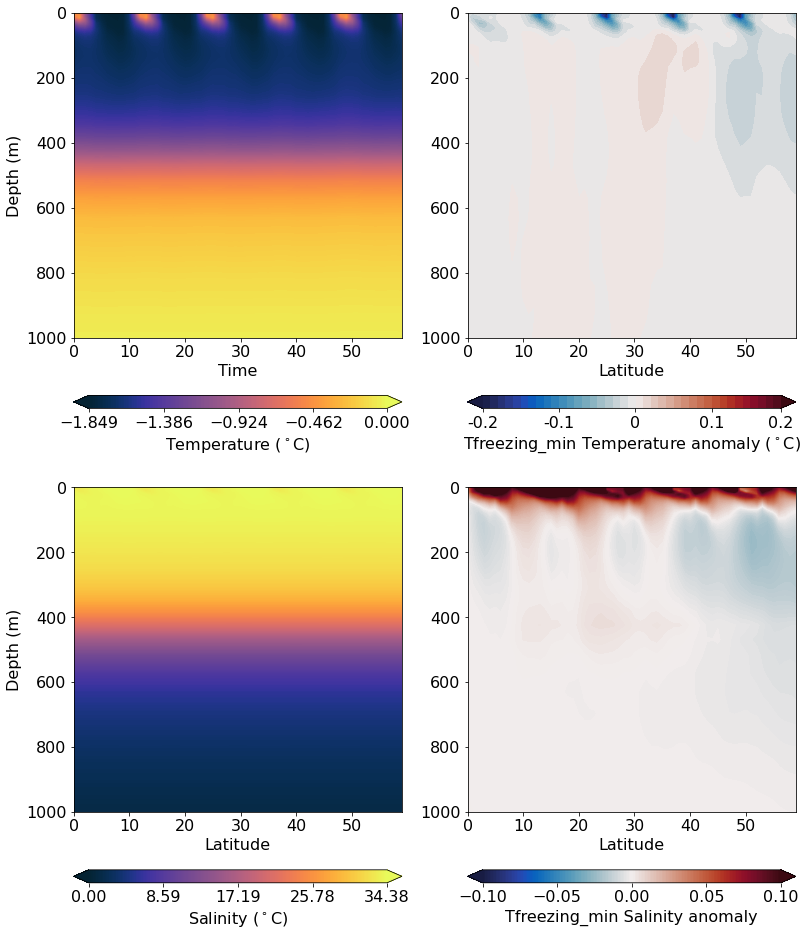

In [23]:
plot_transects(temp_con_transect,temp_Tfreezing_min_transect,salt_con_transect,salt_Tfreezing_min_transect,rho0_con,rho0_Tfreezing_min, st_ocean)

In [24]:
lon1 = -100
lon2 = -150

In [27]:
temp_con_transect,temp_Tfreezing_min_transect,salt_con_transect,salt_Tfreezing_min_transect,rho0_con,rho0_Tfreezing_min, st_ocean = get_transect_data(lon1,lon2)

temp_con_transect done
temp_Tfreezing_min_transect done
salt_con_transect done
salt_Tfreezing_min_transect done
rho0_con done
rho0_Tfreezing_min done


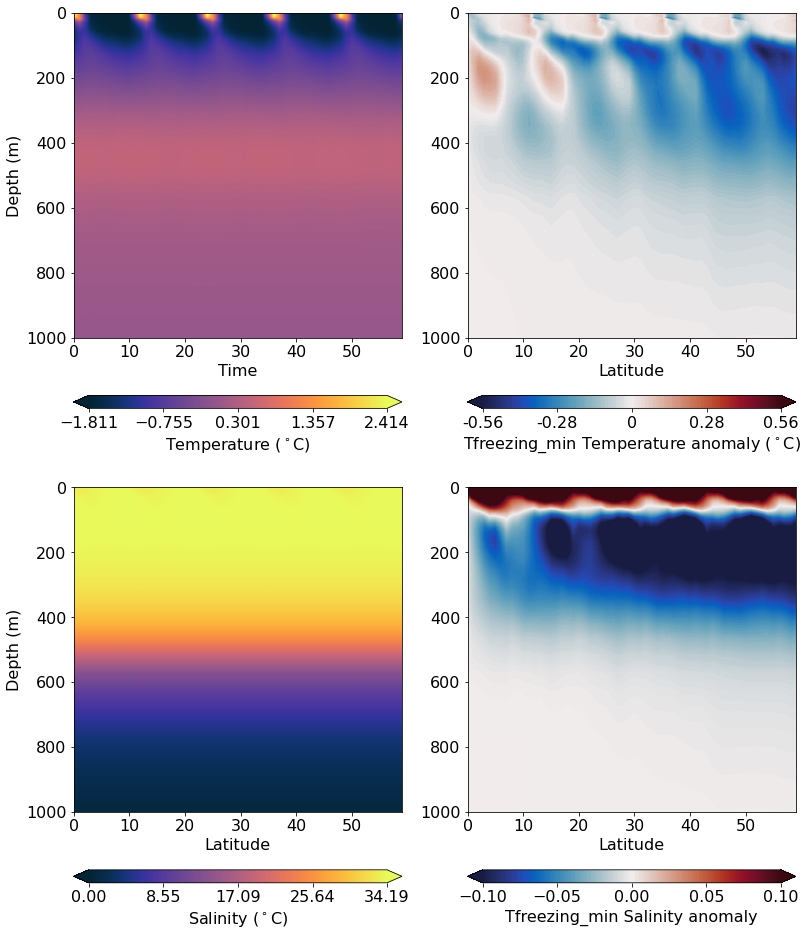

In [28]:
plot_transects(temp_con_transect,temp_Tfreezing_min_transect,salt_con_transect,salt_Tfreezing_min_transect,rho0_con,rho0_Tfreezing_min, st_ocean)